First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-01-25 02:24:09.256261: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 02:24:09.259604: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 02:24:09.263179: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 02:24:09.279460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737789849.542051 1692360 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737789849.54

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# for function later

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

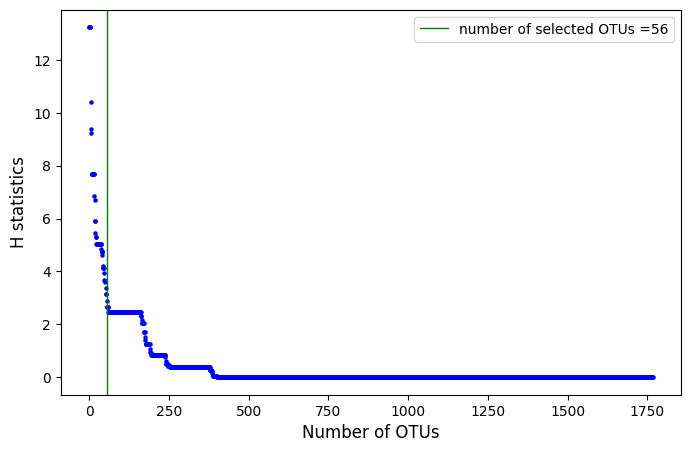

In [6]:
# select the OTUs

selectedresult=FS.SelectMicro_fun(df,burn_label)
    
selectedresult.keys()

In [7]:
selectedOTU_index_list = selectedresult['selected_indices']
selectedASV_list = selectedresult['selected_columnames']
X_FS_list = selectedresult['selected_data']
data = selectedresult['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [8]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [9]:

targetLabel=burn_label
print("The response variable and its counts are:")
print(targetLabel.value_counts())

X_FS = X_FS_list

X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)

X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)

X_FS_lasso,xlabel_FS_lasso0 = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
xlabel_FS_lasso = selectedOTU_index_list[xlabel_FS_lasso0]
X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
xlabel_FS_lasso_ft = selectedOTU_index_list[xlabel_FS_lasso_ft0]

data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lasso":X_FS_lasso,
               "FS_Lassofinetune":X_FS_lasso_ft,
               #"Random":data
              }
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso selected dataset is ',np.shape(X_lasso))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso selected dataset is ',np.shape(X_FS_lasso))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))

The response variable and its counts are:
Burn
Yes    42
No     17
Name: count, dtype: int64
Best alpha: 0.1
Best alpha: 0.05
The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 56)
The shape of the Lasso selected dataset is  (59, 21)
The shape of the Lasso_finetune selected dataset is  (59, 14)
The shape of the FS_Lasso selected dataset is  (59, 15)
The shape of the FS_Lasso_finetune selected dataset is  (59, 15)


In [10]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,classifiers=cls,SMOTE=True)

[1.0, 0.90625, 1.0, 0.8333333333333334, 0.875]
[1.0, 0.84375, 0.8888888888888888, 0.7777777777777779, 0.7083333333333334]
[0.9375, 0.9375, 0.8518518518518519, 0.8333333333333334, 0.875]
[0.75, 0.8125, 0.8333333333333334, 0.9444444444444444, 0.6666666666666667]
[1.0, 1.0, 0.962962962962963, 0.925925925925926, 1.0]
[0.8125, 0.90625, 0.7777777777777778, 1.0, 1.0]
[1.0, 0.96875, 0.925925925925926, 1.0, 0.9166666666666667]
[1.0, 0.8125, 1.0, 0.8888888888888888, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.888888888888889, 1.0, 1.0]
[1.0, 1.0, 1.0, 0.9444444444444444, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.888888888888889, 1.0, 0.9166666666666667]
[1.0, 1.0, 1.0, 0.9444444444444444, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.962962962962963, 1.0, 0.9166666666666667]
[1.0, 1.0, 1.0, 0.9444444444444444, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.962962962962963, 1.0, 0.9166666666666667

In [11]:
print(metric.metric_sum(dict_cm))

                           Accuracy  Precision   Recall   Specification  \
AllFeatures_RF             0.779661  1.000000   0.235294    1.000000      
AllFeatures_SVM            0.745763  0.571429   0.470588    0.857143      
AllFeatures_CatBoost       0.847458  1.000000   0.470588    1.000000      
AllFeatures_NB             0.864407  0.846154   0.647059    0.952381      
SelectMicro_RF             0.898305  1.000000   0.647059    1.000000      
SelectMicro_SVM            0.694915  0.483871   0.882353    0.619048      
SelectMicro_CatBoost       0.881356  1.000000   0.588235    1.000000      
SelectMicro_NB             0.932203  0.842105   0.941176    0.928571      
Lasso_RF                   0.915254  1.000000   0.705882    1.000000      
Lasso_SVM                  0.966102  1.000000   0.882353    1.000000      
Lasso_CatBoost             0.915254  1.000000   0.705882    1.000000      
Lasso_NB                   0.983051  0.944444   1.000000    0.976190      
Lasso_finetune_RF        

In [12]:
dict_cm2 = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,classifiers=['xgboost'],SMOTE=True)

ValueError: could not convert string to float: 'No'

## compare the first 20 index

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements

entries=20

selectedOTU_index_15_list=[arr[:entries] for arr in selectedOTU_index_list]

selectedASVs20_list = []
for i in range(yList.shape[1]):
    selectedASVs = ASVs[selectedOTU_index_15_list[i]]
    selectedASVs20_list.append(selectedASVs)

In [ ]:
targetLabel=burn_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[0]],yList[:,0],selectedASVs20_list[0],
                     posLabel="Yes",posText="Burned",negText="Not Burned")
FS.plotPresenseRatio(X_lassoft_list[0],yList[:,0],ASVs[selectedOTU_index_lassoft_list[0]],
                     posLabel="Yes",posText="Burned",negText="Not Burned")

FS.plotPresenseRatio(X_FS_list[0][:,selectedOTU_index_FS_lassoft_list[0]],yList[:,0],selectedASV_list[0][selectedOTU_index_FS_lassoft_list[0]],
                     posLabel="Yes",posText="Burned",negText="Not Burned")

In [ ]:
targetLabel=un_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[1]],yList[:,1],selectedASVs20_list[1],
                     posLabel="Natural",posText="Natural",negText="Urban")

FS.plotPresenseRatio(X_lassoft_list[1],yList[:,1],ASVs[selectedOTU_index_lassoft_list[1]],
                    posLabel="Natural",posText="Natural",negText="Urban")
FS.plotPresenseRatio(X_FS_list[1][:,selectedOTU_index_FS_lassoft_list[1]],yList[:,1],selectedASV_list[1][selectedOTU_index_FS_lassoft_list[1]],
                     posLabel="Natural",posText="Natural",negText="Urban")

In [ ]:
targetLabel=duration_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[2]],yList[:,2],selectedASVs20_list[2],
                    posLabel="Annual",posText="Annual",negText="Perennial")
FS.plotPresenseRatio(X_lassoft_list[2],yList[:,2],ASVs[selectedOTU_index_lassoft_list[2]],
                    posLabel="Annual",posText="Annual",negText="Perennial")
FS.plotPresenseRatio(X_FS_list[2][:,selectedOTU_index_FS_lassoft_list[2]],yList[:,2],selectedASV_list[2][selectedOTU_index_FS_lassoft_list[2]],
                     posLabel="Annual",posText="Annual",negText="Perennial")

In [ ]:
X_FS_list[2][:,selectedOTU_index_FS_lasso_list[2]].shape

In [ ]:
len(selectedASV_list[2][selectedOTU_index_FS_lassoft_list[2]])

In [ ]:
len(selectedOTU_index_FS_lasso_list[2])

In [ ]:
selectedASV_list[2]

In [ ]:
selectedOTU_index_FS_lassoft_list[2]